In [1]:
# Add ldcpy root to system path
import struct
import sys
from math import log2

import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, '../../../')
import ldcpy

%load_ext autoreload
%autoreload 2


# suppress all of the divide by zero warnings
import warnings

warnings.filterwarnings("ignore")


# display the plots in this notebook
%matplotlib inline

In [2]:
import os

os.environ["HDF5_PLUGIN_PATH"]

'/glade/work/haiyingx/H5Z-ZFP-PLUGIN-unbiased/plugin'

In [9]:
# See here for a list of variables with more information:
# https://www.cesm.ucar.edu/projects/community-projects/LENS/data-sets.html

daily_variables = ["TS", "PRECT", "LHFLX", "FLNS", "ICEFRAC",  "PSL", "Q200",
                   "TAUX", "WSPDSRFAV", "Z500" ]
data_path = "/glade/p/cisl/asap/CAM_lossy_test_data_31/research"

cols_daily = {}
sets = {}
levels = {}
climate_var_arrays = {}

compression_levels = [24, 22, 20, 18, 16, 14, 12, 10, 8]
#daily_variables = ["PRECT"]

for variable in daily_variables:
    print(variable)
    
    new_levels = [f"orig_{variable}"]
    new_sets = [f"{data_path}/daily_orig/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"]
    
    for value in compression_levels:
        new_level = f"zfp_p_{value}_{variable}"
        new_set = f"{data_path}/daily_zfp_hdf5/zfp_p_{value}/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"
        
        new_levels.append(new_level)
        new_sets.append(new_set)
        
    levels[variable] = new_levels
    sets[variable] = new_sets
    
    cols_daily[variable] = ldcpy.open_datasets("cam-fv", [f"{variable}"], sets[variable], levels[variable], chunks={})
    climate_var_arrays[variable] = np.array(cols_daily[variable][variable].isel(time=0).values)

TS
dataset size in GB 1.62

PRECT
dataset size in GB 1.62

LHFLX
dataset size in GB 1.62

FLNS
dataset size in GB 1.62

ICEFRAC
dataset size in GB 1.62

PSL
dataset size in GB 1.62

Q200
dataset size in GB 1.62

TAUX
dataset size in GB 1.62

WSPDSRFAV
dataset size in GB 1.62

Z500
dataset size in GB 1.62



In [29]:
#BG 

bg_daily_variables = ["TS", "PRECT", "LHFLX", "FLNS", "ICEFRAC",  "PSL", "Q200",
                   "TAUX", "WSPDSRFAV", "Z500" ]

bg_cols_daily = {}
bg_sets = {}
bg_levels = {}
data_path = "/glade/p/cisl/asap/CAM_lossy_test_data_31/research/"
bg_climate_var_arrays = {}

bg_compression_levels = [7, 6, 5, 4, 3, 2]
#daily_variables = ["PRECT"]

for variable in bg_daily_variables:
    print(variable)
    
    bg_new_levels = [f"orig_{variable}"]
    bg_new_sets = [f"{data_path}/daily_orig/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"]
    
    for value in bg_compression_levels:
        bg_new_level = f"zfp_p_{value}_{variable}"
        bg_new_set = f"{data_path}/daily_bg/bg_{value}/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"
        
        bg_new_levels.append(bg_new_level)
        bg_new_sets.append(bg_new_set)
        
    bg_levels[variable] = bg_new_levels
    bg_sets[variable] = bg_new_sets
    
    bg_cols_daily[variable] = ldcpy.open_datasets("cam-fv", [f"{variable}"], bg_sets[variable], bg_levels[variable], chunks={})
    bg_climate_var_arrays[variable] = np.array(bg_cols_daily[variable][variable].isel(time=0).values)

    

TS
dataset size in GB 1.13

PRECT
dataset size in GB 1.13

LHFLX
dataset size in GB 1.13

FLNS
dataset size in GB 1.13

ICEFRAC
dataset size in GB 1.13

PSL
dataset size in GB 1.13

Q200
dataset size in GB 1.13

TAUX
dataset size in GB 1.13

WSPDSRFAV
dataset size in GB 1.13

Z500
dataset size in GB 1.13



In [34]:
#import bitstring 
import numpy as np


def binary(num):
    return ''.join(f'{c:0>8b}' for c in struct.pack('!f', num))

#def binary2(f):
#    f1 = bitstring.BitArray(float=f, length=32)
#    return f1.bin


# NOTE: They only look backward
def get_prev_bit(bit_pos):
    return [bit_pos[0]-1, bit_pos[1]]

N_BITS = 32

def getbpe(data_array, x_index, title, compression_levels):
    dict_list_H = []
    for i in range(N_BITS-1):
        new_dict = {"00": 0,
                    "01": 0,
                    "10": 0,
                    "11": 0}
        dict_list_H.append(new_dict)
        
    num_measurements = 0
    for y in range(1, data_array.shape[1]):
        for z in range(data_array.shape[2]):
            num_measurements += 1
            
            bit_pos = [y, z]
            current_data = data_array[x_index][y][z]
            current_data = binary(current_data)
            
            adj_data_index = get_prev_bit(bit_pos)
            y_adj, z_adj = adj_data_index
            adj_data = data_array[x_index][y_adj][z_adj]
            adj_data = binary(adj_data)
            
            for i in range(N_BITS-1):
                current_bit = int(current_data[i])
                adjacent_bit = int(adj_data[i])
                
                p00 = p01 = p10 = p11 = 0
                if adjacent_bit == 0 and current_bit == 0:
                    p00 = 1
                elif adjacent_bit == 1 and current_bit == 0:
                    p10 = 1
                elif adjacent_bit == 0 and current_bit == 1:
                    p01 = 1
                elif adjacent_bit == 1 and current_bit == 1:
                    p11 = 1
                    
                dict_list_H[i]["00"] += p00
                dict_list_H[i]["01"] += p01
                dict_list_H[i]["10"] += p10
                dict_list_H[i]["11"] += p11
                
    I = []
    for bit_pos_dict in dict_list_H:
        p00 = np.divide(bit_pos_dict["00"], num_measurements, dtype=np.float64)
        p01 = np.divide(bit_pos_dict["01"] , num_measurements, dtype=np.float64)
        p10 = np.divide(bit_pos_dict["10"] , num_measurements, dtype=np.float64)
        p11 = np.divide(bit_pos_dict["11"] , num_measurements, dtype=np.float64)
        
        # print("p00 = ", p00, "p01 = ", p01, "p10 = ", p10, "p11 = ", p11)
        p0 = p00 + p10  # current bit is 0
        p1 = p11 + p01  # current bit is 1
        p0_prev = p00 + p01 # prev bit was 0
        p1_prev = p11+ p10  # prev bit was 1
        
        # METHOD 1
        # From (4) in paper                
        # mutual information
        MI = 0.0
        if p00 > 0.0:
            MI +=  p00 * np.log2(p00/p0_prev/p0)
        if p11 > 0.0:
            MI +=  p11 * np.log2(p11/p1_prev/p1)    
        if p01 > 0.0:
            MI +=  p01 * np.log2(p01/p0_prev/p1)    
        if p10 > 0.0:
            MI +=  p10 * np.log2(p10/p1_prev/p0)    
      
        #print("MI_1 = ", MI)
        I.append(MI)
    
        # METHOD 2
        # (6) in paper should be: Hs + Hr - H0 - H1
         #info content: prob of a current bit being: p0 or p1
        Hr = Hs = 0.0
        if p0_prev> 0.0:
            Hr -= p0_prev*np.log2(p0_prev)
        if p1_prev > 0.0:
            Hr -= p1_prev*np.log2(p1_prev)
        if p0 > 0.0:
            Hs -= p0 *np.log2(p0)
        if p1  > 0.0:
            Hs -= p1*np.log2(p1)

        # H0 => preceeding bit is 0    
        H0 = 0.0
        if p00 > 0.0:
            H0 -= p00 * np.log2(p00)
        if p01 > 0.0:
            H0 -= p01 * np.log2(p01)
        #H1 => preceeding bit is 1
        H1 = 0.0
        if p10 != 0.0:
            H1 -= p10 * np.log2(p10)
        if p11 != 0.0:
            H1 -= p11 * np.log2(p11)
        MI2 = Hr + Hs - H0 - H1
        #print("MI_2 = ", MI2)
        if not np.isclose(MI, MI2, rtol=1e-05, atol=1e-08, equal_nan=False):
            print("ISSUE")
    
    plt.plot(I)
    plt.ylabel("Information content")
    plt.xlabel("Bit position")

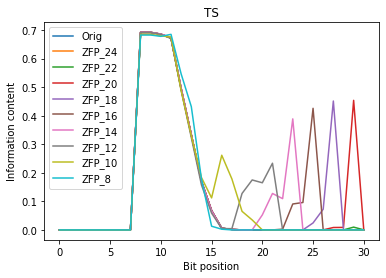

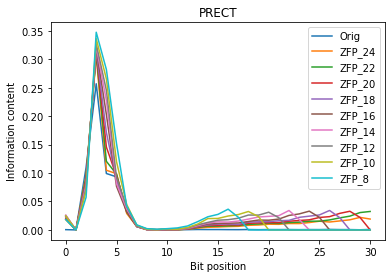

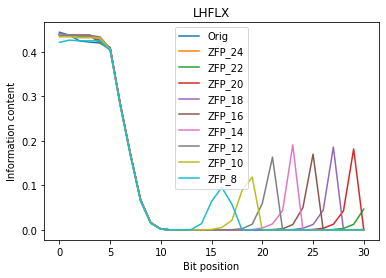

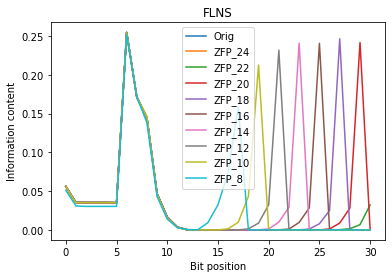

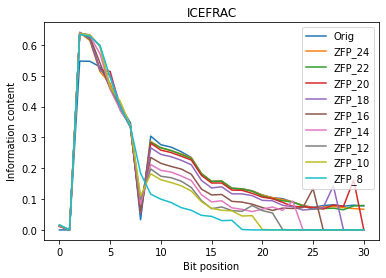

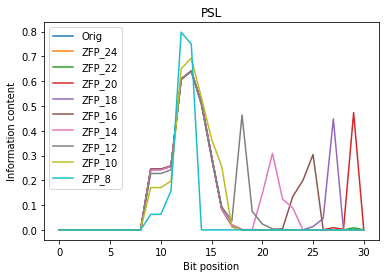

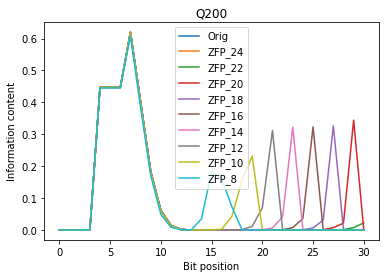

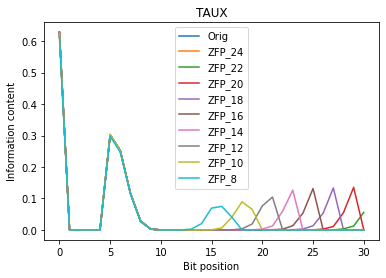

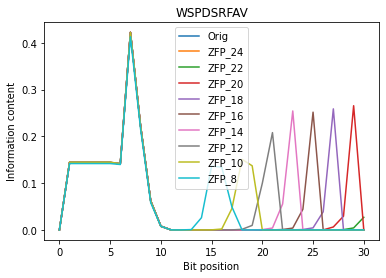

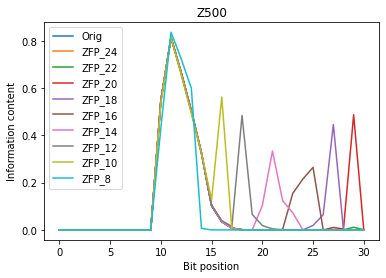

In [35]:
#ZFP
compression_levels = [24, 22, 20, 18, 16, 14, 12, 10, 8]
compression_levels = ["ZFP_" + str(x) for x in compression_levels]
compression_levels = ["Orig"] + compression_levels

for daily_variable in daily_variables:
    arr = climate_var_arrays[daily_variable]
    for i in range(arr.shape[0]):
        getbpe(arr, i, daily_variable, compression_levels)
    plt.title(daily_variable)
    plt.legend(compression_levels)
    plt.show()

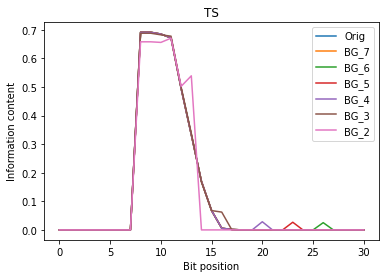

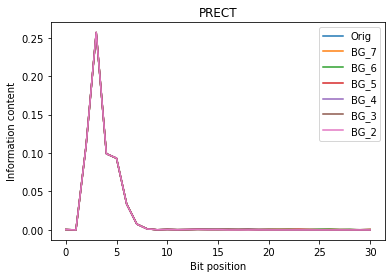

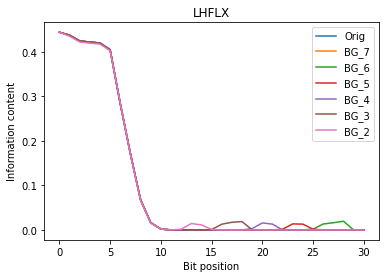

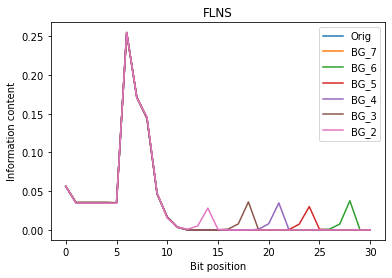

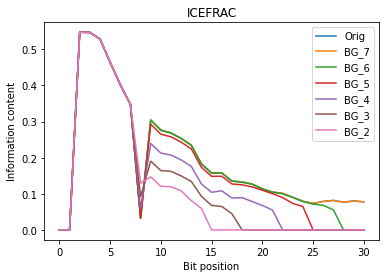

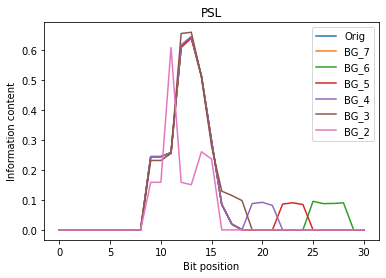

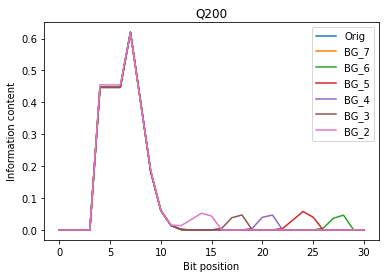

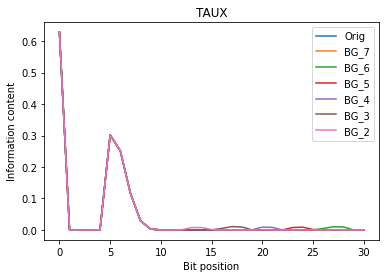

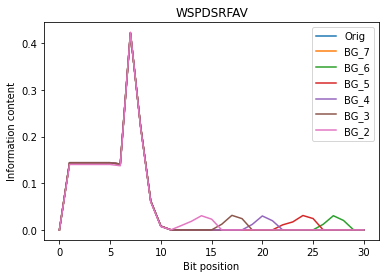

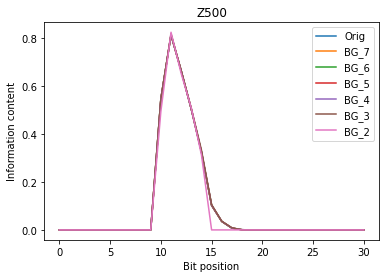

In [36]:
#BG
bg_compression_levels = [7,6,5,4,3,2]
bg_compression_levels = ["BG_" + str(x) for x in bg_compression_levels]
bg_compression_levels = ["Orig"] + bg_compression_levels

for daily_variable in bg_daily_variables:
    arr = bg_climate_var_arrays[daily_variable]
    for i in range(arr.shape[0]):
        getbpe(arr, i, daily_variable, bg_compression_levels)
    plt.title(daily_variable)
    plt.legend(bg_compression_levels)
    plt.show()